# WSC Project - Detection model experiments

In [1]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')
import ast
import pickle

# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Machine Learning imports
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support

# Jupyter settings
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings for full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# load and expr pre-process

## load data

In [2]:
ACTIONS = list(set(pd.read_csv("data/actions.csv")["parameter"]))
pseudo_df = pd.read_csv("data/pseudo_actions_labels_with_id.csv")[['sample_id', 'action_detected']]
transcripts_folds_df = pd.read_csv('data/transcripts_folds.csv')

with open('data/actions_processed_to_action.json', 'r') as f:
    actions_map = json.load(f)
inverse_actions_map = {v: k for k, v in actions_map.items()}

with open('data/all_df_preds_DeBERTa-v3-base-mnli-fever-anli.json', 'r') as f:
    deberta_action_predictions_dict = json.load(f)

augmented_texts_df = pd.read_csv('data/augmented_texts_processed.csv')[['sample_id', 'augmented_text', 'tokenized_augmented_text', 'action']]

## prepare expr_df

In [3]:

features_df = transcripts_folds_df[['sample_id', 'Text', 'tokenized_text', 'events', 'actions_in_text', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5']]

expr_df = pseudo_df.merge(features_df, on='sample_id', how='inner').rename(columns={'action_detected': 'actions_pseudo_label', 'actions_in_text': 'actions_str_detected', 'Text': 'transcript_text'})

expr_df['actions_pseudo_label'] =  expr_df['actions_pseudo_label'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
expr_df['actions_str_detected'] = expr_df['actions_str_detected'].apply(
lambda x: [inverse_actions_map.get(a, a) for a in (ast.literal_eval(x) if isinstance(x, str) else x)])

## add deberta predictions

In [4]:
def get_deberta_action_preds(threshold):
    return [
        [label
            for idx, (label, score) in enumerate(zip(pred['labels'], pred['scores']))
            if score > threshold * (idx + 1)]
        for pred in deberta_action_predictions_dict.values()
    ]

deberta_action_preds_03 = get_deberta_action_preds(threshold=0.3)
deberta_action_preds_02 = get_deberta_action_preds(threshold=0.2)

expr_df['deberta_action_predictions_t03'] = deberta_action_preds_03
expr_df['deberta_action_predictions_t02'] = deberta_action_preds_02

## evaluation utils

In [49]:
def action_metrics(df, preds_col):
    mlb = MultiLabelBinarizer()
    y_true = mlb.fit_transform(df['actions_pseudo_label'])
    y_pred = mlb.transform(df[preds_col])
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    return pd.DataFrame({'action': mlb.classes_, 'precision': precision, 'recall': recall, 'f1': f1})


def plot_action_metric(metrics_df, action_counts, metric='f1'):
    metrics_df = metrics_df.copy()
    metrics_df['n_samples'] = metrics_df['action'].map(action_counts).fillna(0).astype(int)
    metrics_df_sorted = metrics_df.sort_values('n_samples')

    plt.figure(figsize=(12, 8))
    bars = plt.barh(metrics_df_sorted['action'], metrics_df_sorted[metric])
    plt.xlabel(f'{metric.capitalize()} Score')
    plt.title(f'{metric.capitalize()} Score per Action (Test set)')
    for bar, val, n in zip(bars, metrics_df_sorted[metric], metrics_df_sorted['n_samples']):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.2f} (n={n})", va='center', fontsize=12)
    plt.tight_layout()
    plt.show()



def compute_metrics_summary(metrics_df, action_counts):
    avg_metrics_df = metrics_df.groupby('action')[['precision', 'recall', 'f1']].mean().round(2).reset_index()
    metrics_df = metrics_df.copy()
    metrics_df['support'] = metrics_df['action'].map(action_counts).fillna(0).astype(int)
    metrics_summary = {
        'Weighted F1': ((metrics_df['f1'] * metrics_df['support']).sum() / metrics_df['support'].sum()).round(3),
        'Macro F1': avg_metrics_df['f1'].mean().round(3),
        'Weighted recall': ((metrics_df['recall'] * metrics_df['support']).sum() / metrics_df['support'].sum()).round(3),
        'Macro recall': avg_metrics_df['recall'].mean().round(3),
        'Weighted precision': ((metrics_df['precision'] * metrics_df['support']).sum() / metrics_df['support'].sum()).round(3),
        'Macro precision': avg_metrics_df['precision'].mean().round(3)
    }
    metrics_summary_df = pd.DataFrame(metrics_summary, index=[0])
    return metrics_summary_df


def evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action):
    avg_metrics_df = metrics_df.groupby('action')[['precision', 'recall', 'f1']].mean().round(2).reset_index()
    metrics_summary_df = compute_metrics_summary(metrics_df, action_counts)
    
    if plot_per_action:
        plot_action_metric(avg_metrics_df, action_counts, metric='f1')
        plot_action_metric(avg_metrics_df, action_counts, metric='precision')
        plot_action_metric(avg_metrics_df, action_counts, metric='recall')
    return metrics_summary_df

## experiment pipelines and utils

In [37]:
def concat_augmentations_to_fold_df(fold_train_df):
    augmented_texts_train = augmented_texts_df[augmented_texts_df['sample_id'].isin(fold_train_df['sample_id'])]
    augmented_texts_train = augmented_texts_train.rename(columns={'augmented_text': 'transcript_text', 'action': 'actions_pseudo_label', 'tokenized_augmented_text': 'tokenized_text'})
    augmented_texts_train['actions_pseudo_label'] = augmented_texts_train['actions_pseudo_label'].apply(lambda x: [x])
    augmented_texts_train = augmented_texts_train.merge(
        fold_train_df.drop(['actions_pseudo_label', 'transcript_text', 'tokenized_text'], axis=1), 
        on='sample_id', 
        how='inner'
    )
    return pd.concat([fold_train_df, augmented_texts_train], ignore_index=True)


In [38]:
def tfidf_action_prediction(**kwargs):
    train_df = kwargs['train_df']
    test_df = kwargs['test_df']
    text_col = kwargs['text_col']
    predict_threshold = kwargs.get('predict_threshold', 0.5)
    mlb = MultiLabelBinarizer()
    
    y = mlb.fit_transform(train_df['actions_pseudo_label'])
    
    if text_col == 'tokenized_text_str':
        train_df['tokenized_text_str'] = train_df['tokenized_text'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else ' '.join(x))
        test_df['tokenized_text_str'] = test_df['tokenized_text'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else ' '.join(x))
    
    
    train_df['tokenized_events_str'] = train_df['events'].apply(lambda x: ' '.join([(i or '') for i in (ast.literal_eval(x) if isinstance(x, str) else x)]))
    test_df['tokenized_events_str'] = test_df['events'].apply(lambda x: ' '.join([(i or '') for i in (ast.literal_eval(x) if isinstance(x, str) else x)]))

    get_text = FunctionTransformer(lambda X: X[text_col], validate=False)
    get_events = FunctionTransformer(lambda X: X['tokenized_events_str'], validate=False)
    sublinear_tf = True
    
    # solver = 'lbfgs'
    solver = 'liblinear'
    
    pipeline = Pipeline([
       ('features', FeatureUnion([
           ('word_tfidf_text', Pipeline([('sel', get_text), ('tfidf', TfidfVectorizer(ngram_range=(1,3), analyzer='word', sublinear_tf=sublinear_tf))])),
           ('char_tfidf_text', Pipeline([('sel', get_text), ('tfidf', TfidfVectorizer(ngram_range=(2,3), analyzer='char', sublinear_tf=sublinear_tf))])),
           ('word_tfidf_events', Pipeline([('sel', get_events), ('tfidf', TfidfVectorizer(ngram_range=(1,2), analyzer='word', sublinear_tf=sublinear_tf))])),
       ])),
       ('classifier', MultiOutputClassifier(LogisticRegression(class_weight='balanced', solver=solver, max_iter=2000, C=0.5)))
    ])
    X = train_df[[text_col,'tokenized_events_str']]
    X_test = test_df[[text_col,'tokenized_events_str']]
    pipeline.fit(X, y)
    predictions_proba = pipeline.predict_proba(X_test)
    proba_of_action = np.column_stack([pred[:, 1] for pred in predictions_proba])
    predictions = (proba_of_action > predict_threshold).astype(int)
    return mlb.inverse_transform(predictions)


def string_matching_prediction(**kwargs):
    test_df = kwargs['test_df']
    return test_df['actions_str_detected'].tolist()


def deberta_action_predictions_func(**kwargs):
    test_df = kwargs['test_df']
    deberta_predict_col = kwargs['deberta_predict_col']
    return test_df[deberta_predict_col].tolist()
    

def tfidf_or_string_matching_action_prediction(**kwargs):
    predicted_labels_tfidf = tfidf_action_prediction(**kwargs)
    predicted_labels_string_match = string_matching_prediction(**kwargs)
    combined_predicted_labels = [list(set(list(l1) + list(l2))) for l1, l2 in zip(predicted_labels_tfidf, predicted_labels_string_match)]
    return combined_predicted_labels

def tfidf_or_deberta_or_string_matching_action_prediction(**kwargs):
    predicted_labels_tfidf = tfidf_action_prediction(**kwargs)
    predicted_labels_deberta = deberta_action_predictions_func(**kwargs)
    predicted_labels_string_match = string_matching_prediction(**kwargs)
    combined_predicted_labels = [list(set(list(l1) + list(l2) + list(l3))) for l1, l2, l3 in zip(predicted_labels_tfidf, predicted_labels_deberta, predicted_labels_string_match)]
    return combined_predicted_labels

# Run Experiments

In [39]:
expr_df['deberta_action_predictions_t02'].apply(len).value_counts()

deberta_action_predictions_t02
1    1059
0      44
2       2
Name: count, dtype: int64

## Validaiton sets

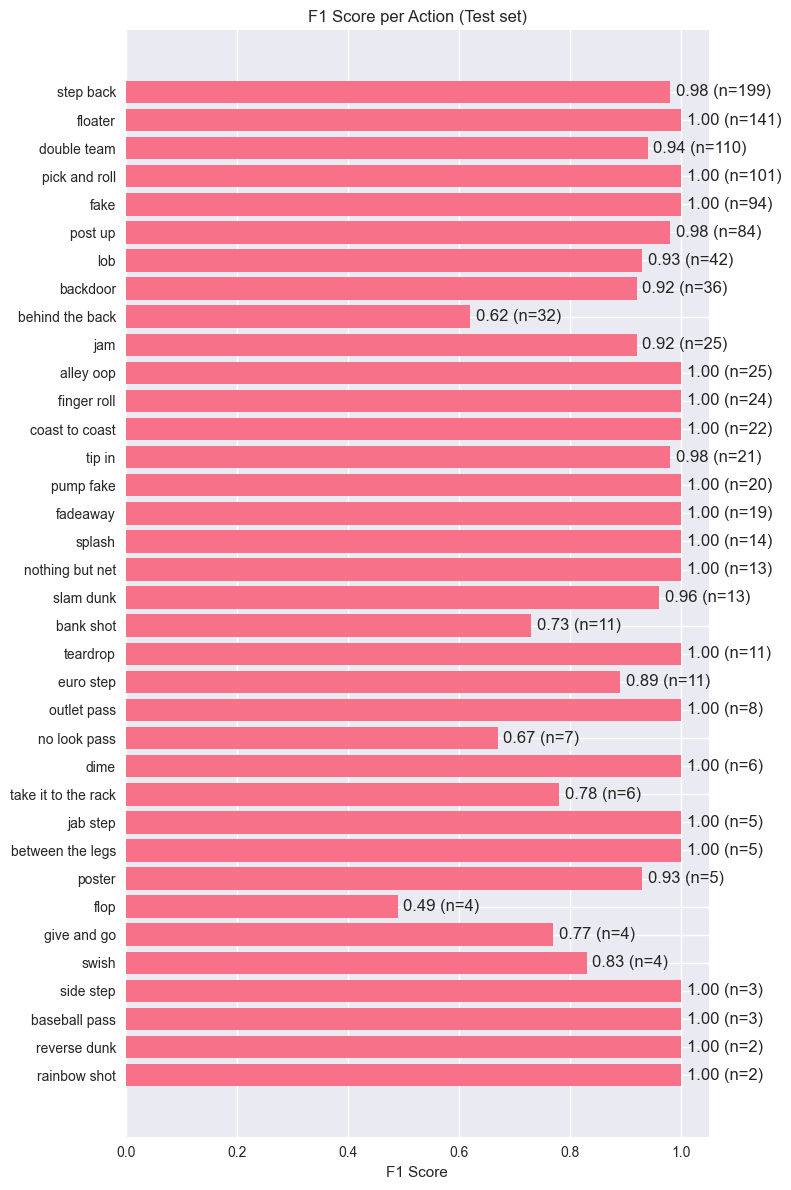

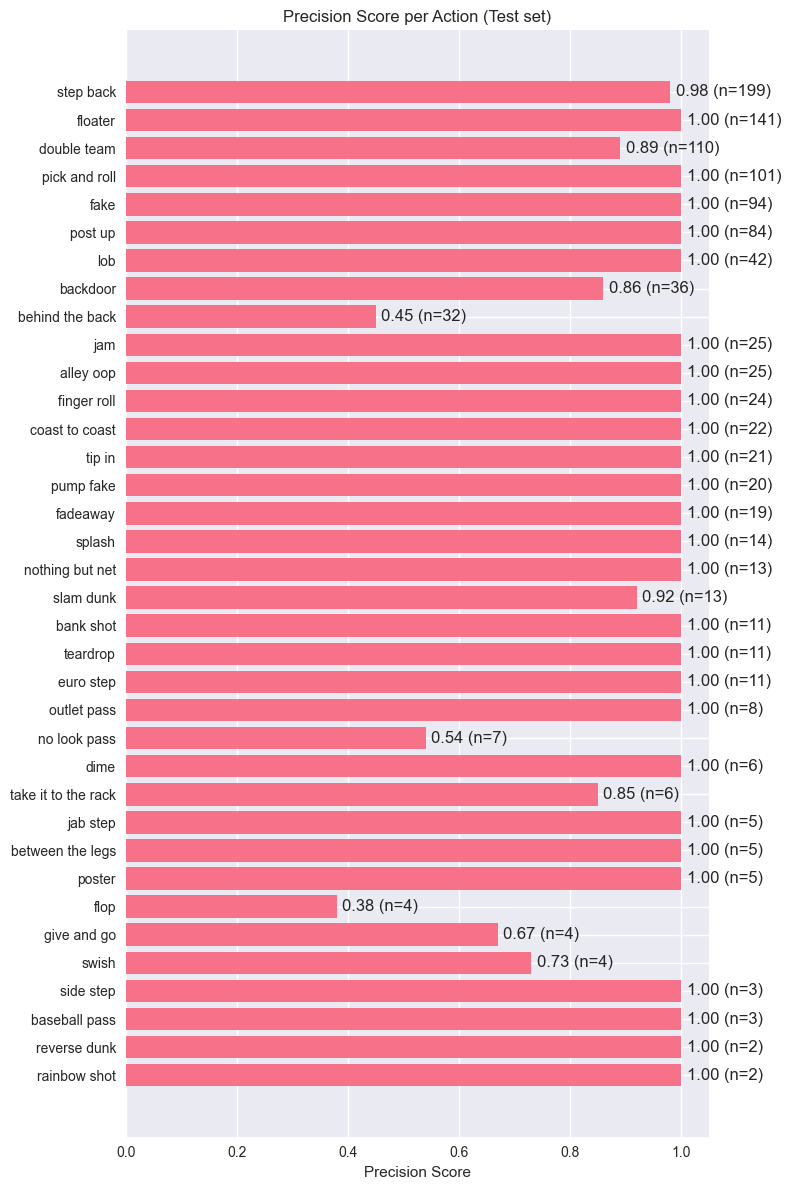

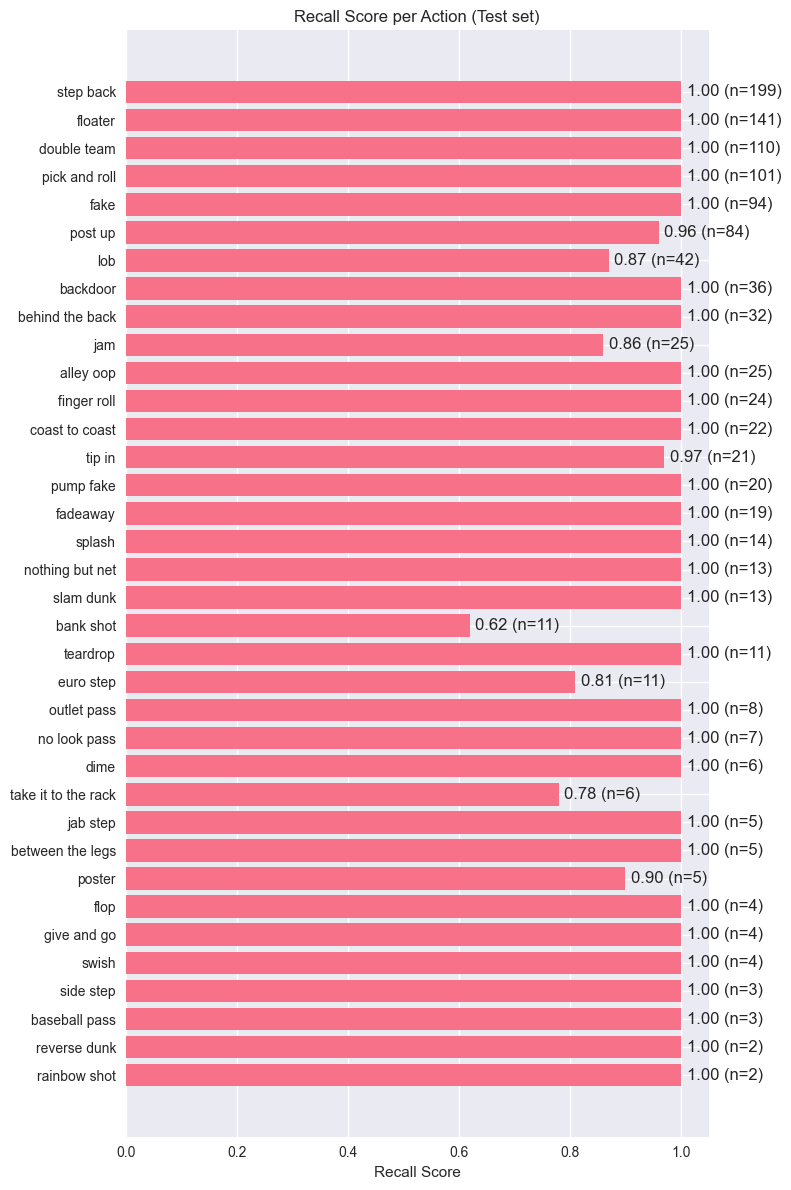

,Weighted F1,Macro F1,Weighted recall,Macro recall,Weighted precision,Macro precision,model
0,0.873,0.595,0.838,0.550,0.937,0.696,TFIDF+LR
1,0.981,0.914,0.969,0.899,0.998,0.940,String matching
2,0.862,0.811,0.833,0.820,0.914,0.851,Deberta
3,0.976,0.894,0.977,0.906,0.981,0.903,TFIDF-LR+String matching
4,0.961,0.926,0.980,0.966,0.956,0.924,TFIDF-LR+Deberta+String matching


In [45]:
AUGMENT_DATA = True
# text_col_for_tfidf = 'transcript_text'
text_col_for_tfidf = 'tokenized_text_str'

df = expr_df.copy()
action_counts = df['actions_pseudo_label'].explode().value_counts()

def run_expr_predictions(inference_func, predict_threshold=None , deberta_predict_col=None):
   metrics_dfs = []
   for fold_idx in range(1, 6):
      fold_col = f'fold{fold_idx}'
      fold_train_df = df[df[fold_col] == 'train']
      if AUGMENT_DATA:
         fold_train_df = concat_augmentations_to_fold_df(fold_train_df)
      fold_val_df = df[df[fold_col] == 'val']
      predicted_labels = inference_func(
          train_df=fold_train_df,
          test_df=fold_val_df,
          text_col=text_col_for_tfidf,
          deberta_predict_col=deberta_predict_col,
          predict_threshold=predict_threshold
      )
      
      fold_val_df = fold_val_df.copy()
      preds_col = f'baseline_actions_pred_{fold_col}'
      fold_val_df[preds_col] = [list(label) for label in predicted_labels]
      # fold_val_df[preds_col] = fold_val_df[preds_col] > THRESHOLD
      metrics_df = action_metrics(fold_val_df, preds_col)
      metrics_df['fold'] = fold_idx
      metrics_dfs.append(metrics_df)

   metrics_df = pd.concat(metrics_dfs, ignore_index=True)
   return metrics_df

# print('\n\nTFIDF + LR: ')
metrics_df = run_expr_predictions(inference_func=tfidf_action_prediction, predict_threshold=0.5)
metrics_summary_tfidf = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nString matching: ')
metrics_df = run_expr_predictions(inference_func=string_matching_prediction)
metrics_summary_string_matching = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nDeberta prediction: ')
metrics_df = run_expr_predictions(inference_func=deberta_action_predictions_func, deberta_predict_col='deberta_action_predictions_t02')
metrics_summary_deberta = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nTFIDF-LR + String matching: ')
metrics_df = run_expr_predictions(inference_func=tfidf_or_string_matching_action_prediction, predict_threshold=0.5)
metrics_summary_tfidf_string_matching = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nTFIDF-LR + Deberta + String matching: ')
metrics_df = run_expr_predictions(inference_func=tfidf_or_deberta_or_string_matching_action_prediction, deberta_predict_col='deberta_action_predictions_t03', predict_threshold=0.7)
metrics_summary_tfidf_string_matching_deberta = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=True)

metrics_summary_df = pd.concat([
    metrics_summary_tfidf.assign(model='TFIDF+LR'),
    metrics_summary_string_matching.assign(model='String matching'),
    metrics_summary_deberta.assign(model='Deberta'),
    metrics_summary_tfidf_string_matching.assign(model='TFIDF-LR+String matching'),
    metrics_summary_tfidf_string_matching_deberta.assign(model='TFIDF-LR+Deberta+String matching')
], ignore_index=True)
display(metrics_summary_df)



## Test set

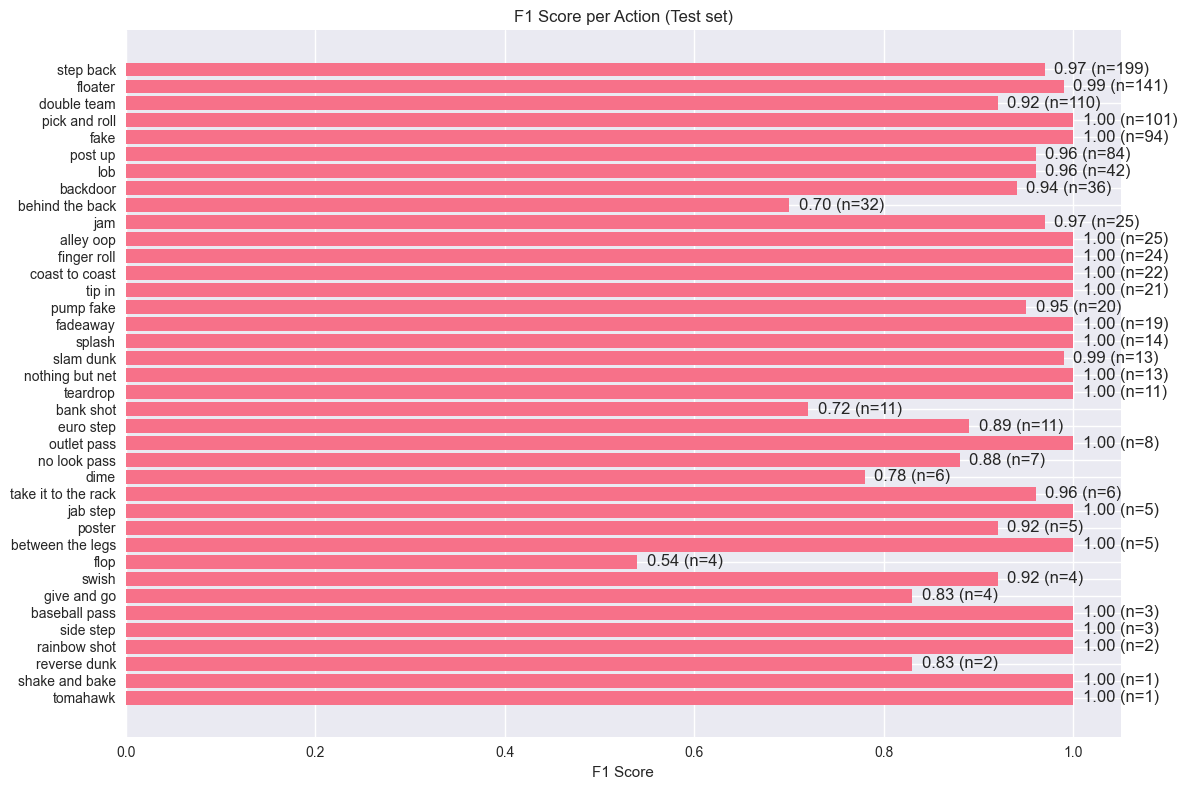

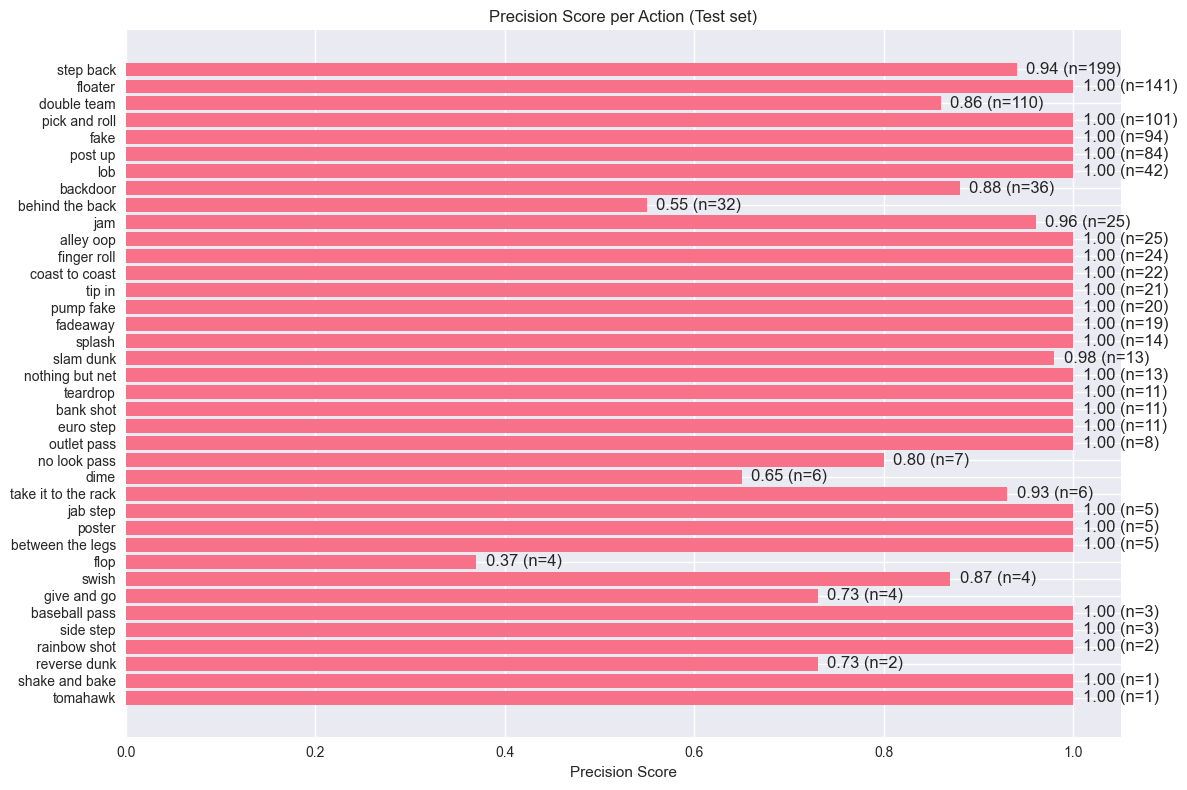

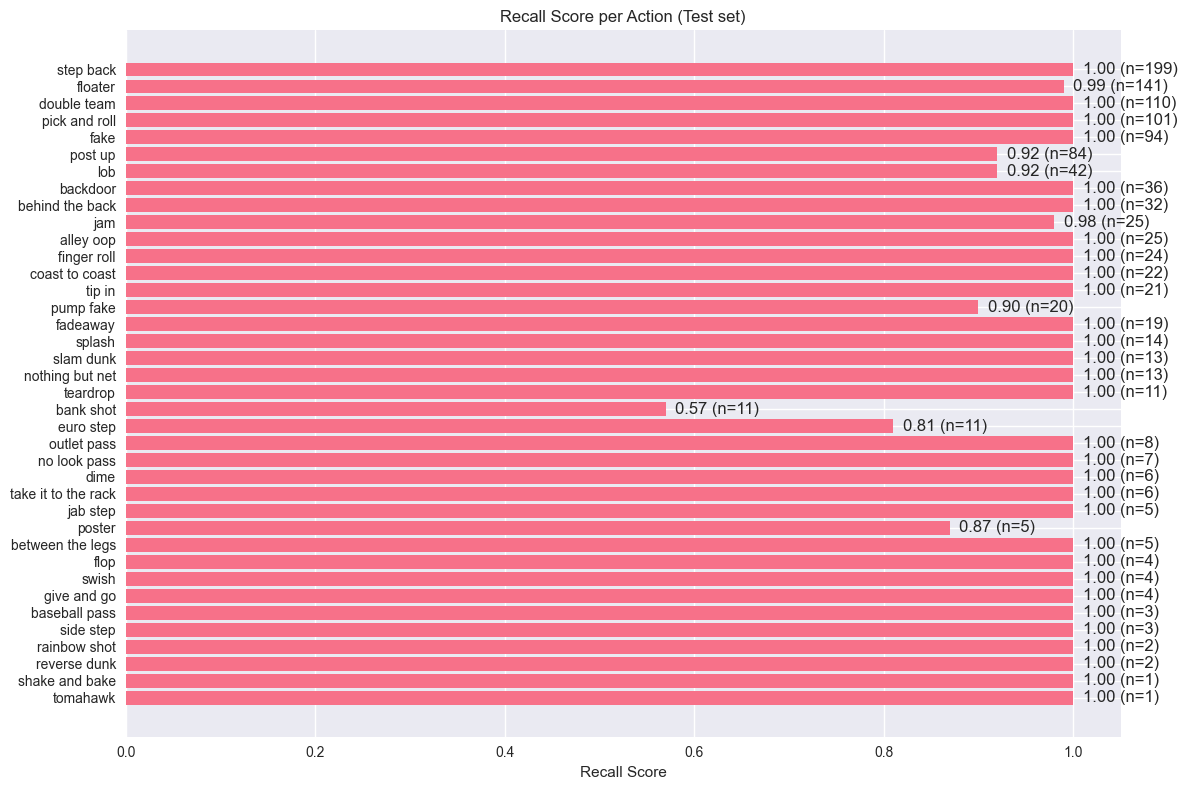

,Weighted F1,Macro F1,Weighted recall,Macro recall,Weighted precision,Macro precision,model
0,0.940,0.742,0.926,0.717,0.965,0.797,TFIDF+LR
1,0.981,0.962,0.969,0.951,0.998,0.991,String matching
2,0.850,0.784,0.815,0.778,0.909,0.832,Deberta
3,0.979,0.958,0.982,0.962,0.981,0.971,TFIDF-LR+String matching
4,0.961,0.937,0.980,0.973,0.951,0.928,TFIDF-LR+Deberta+String matching


In [50]:
AUGMENT_DATA = True
# text_col_for_tfidf = 'transcript_text'
text_col_for_tfidf = 'tokenized_text_str'

df = expr_df.copy()
action_counts = df['actions_pseudo_label'].explode().value_counts()

def run_expr_predictions(inference_func, predict_threshold=None , deberta_predict_col=None):
   metrics_dfs = []
   for fold_idx in range(1, 6):
      fold_col = f'fold{fold_idx}'
      fold_train_df = df[(df[fold_col] == 'train') | (df[fold_col] == 'val')]
      if AUGMENT_DATA:
         fold_train_df = concat_augmentations_to_fold_df(fold_train_df)
      fold_val_df = df[df[fold_col] == 'test']
      predicted_labels = inference_func(
          train_df=fold_train_df,
          test_df=fold_val_df,
          text_col=text_col_for_tfidf,
          deberta_predict_col=deberta_predict_col,
          predict_threshold=predict_threshold
      )
      
      fold_val_df = fold_val_df.copy()
      preds_col = f'baseline_actions_pred_{fold_col}'
      fold_val_df[preds_col] = [list(label) for label in predicted_labels]
      # fold_val_df[preds_col] = fold_val_df[preds_col] > THRESHOLD
      metrics_df = action_metrics(fold_val_df, preds_col)
      metrics_df['fold'] = fold_idx
      metrics_dfs.append(metrics_df)

   metrics_df = pd.concat(metrics_dfs, ignore_index=True)
   return metrics_df

# print('\n\nTFIDF + LR: ')
metrics_df = run_expr_predictions(inference_func=tfidf_action_prediction, predict_threshold=0.5)
metrics_summary_tfidf = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nString matching: ')
metrics_df = run_expr_predictions(inference_func=string_matching_prediction)
metrics_summary_string_matching = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nDeberta prediction: ')
metrics_df = run_expr_predictions(inference_func=deberta_action_predictions_func, deberta_predict_col='deberta_action_predictions_t02')
metrics_summary_deberta = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nTFIDF-LR + String matching: ')
metrics_df = run_expr_predictions(inference_func=tfidf_or_string_matching_action_prediction, predict_threshold=0.5)
metrics_summary_tfidf_string_matching = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=False)

# print('\n\nTFIDF-LR + Deberta + String matching: ')
metrics_df = run_expr_predictions(inference_func=tfidf_or_deberta_or_string_matching_action_prediction, deberta_predict_col='deberta_action_predictions_t03', predict_threshold=0.7)
metrics_summary_tfidf_string_matching_deberta = evaluate_and_plot_metrics(metrics_df, action_counts, plot_per_action=True)

metrics_summary_df = pd.concat([
    metrics_summary_tfidf.assign(model='TFIDF+LR'),
    metrics_summary_string_matching.assign(model='String matching'),
    metrics_summary_deberta.assign(model='Deberta'),
    metrics_summary_tfidf_string_matching.assign(model='TFIDF-LR+String matching'),
    metrics_summary_tfidf_string_matching_deberta.assign(model='TFIDF-LR+Deberta+String matching')
], ignore_index=True)
display(metrics_summary_df)


